In [1]:
from qiskit import QuantumCircuit, Aer, execute, IBMQ
from qiskit.providers import JobStatus
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel
from qiskit.tools.visualization import plot_histogram
from math import *
#import import_ipynb
import numpy as np
import math
import itertools

from network_setup import *

#import probabilities as prob

In [2]:
#statesStayHome, statesTests, statesCases = prob.get_lesser_model_states()
#basic_graph = prob.get_conditional_probability(statesStayHome, statesTests, statesCases)[2]

"""
Order of Cases conditional probabilities in graph: 
P(C=0|A=0,B=0), P(C=1|A=0,B=0), P(C=0|A=0,B=1), P(C=1|A=0,B=1), P(C=0|A=1,B=0), P(C=1|A=1,B=0), P(C=0|A=1,B=1), P(C=1|A=1,B=1)
From Fig 4 in https://arxiv.org/pdf/2004.14803.pdf -- 
our order is first col first row, first col second row, second col first row, etc. 
so the first two probabilities add up to one, the third and fourth add up to one, etc. 
"""
#print(basic_graph)
oil_graph = {'IR': ([], [.75, .25]), # From 2004.14803, Fig 10
         'SM': (['IR'], [.3, .7, .8, .2]), #P(0|!A), P(1|!A), P(0|A), P(1|A)
         'OI': ([], [.6, .4]),
         'SP': (['OI', 'SM'], [.9, .1, .5, .5, .4, .6, .2, .8])
        }

mallard_test_graph = {'MaskN,MaskY': ([],[0.3,0.7]),
                      'TestGreat,TestLess': ([],[0.4,0.6]),
                      'Work0,Work1,Work2,Work3': ([],[0.2,0.2,0.2,0.4]),
                      'Rec0,Rec1,Rec2,Rec3': ([],[0.1,0.2,0.3,0.4]),
                      'Race0,Race1,Race2,Race3': ([],[0.4,0.1,0.1,0.4]),
                      'Poverty0,Poverty1,Poverty2,Poverty3': ([],[0.7,0.1,0.1,0.1]),
                      'AgeLess,AgeMore': ([],[0.5,0.5]),
                      'Health0,Health1,Health2,Health3': ([],[0.5,0.1,0.2,0.2]),
                      'Cases0,Cases1,Cases2,Cases3': (['MaskN,MaskY', 'TestGreat,TestLess',
                                                       'Work0,Work1,Work2,Work3','Rec0,Rec1,Rec2,Rec3',
                                                       'Poverty0,Poverty1,Poverty2,Poverty3'],
                                                      []),
                      'Deaths0,Deaths1': (['AgeLess,AgeMore','Health0,Health1,Health2,Health3',
                                           'Race0,Race1,Race2,Race3','Poverty0,Poverty1,Poverty2,Poverty3'],
                                          [])}


In [3]:
#TODO assertAlmostEqual(angle_from_probability(0.2, 0.8), 2.2143)
def angle_from_probability(p0, p1):
    '''Equation 20 from https://arxiv.org/pdf/2004.14803.pdf'''
    angle = 2 * atan2(sqrt(p1), sqrt(p0))
    return angle

In [4]:
def find_num_states(numprobs, in_edges):
    if in_edges == 0: # if parent node
        numstates = numprobs
    elif in_edges > 0: # if child node
        numstates = (numprobs/(2**(in_edges+1))) * 2
    return numstates

def find_numstates_parents(graph, parentvarnames):
    """Eqn 21 from https://arxiv.org/pdf/2004.14803.pdf"""
    numstates_parents = 0
    for i in range(len(parentvarnames)):
        parent = parentvarnames[i]
        parentprobs = graph[parent]
        numprobs = len(parentprobs[1]) # number of states if parent node, number of conditional states if child node
        in_edges = len(graph[parent][0]) # aka num of parents of this parent
        numstates_parents += find_num_states(numprobs, in_edges)        
        
    return numstates_parents
    
def num_qbits_needed_general(graph): 
    sumterm = 0
    ancillaterms = []
    varnum = 0
    for var in graph:
        probs = graph[var]
        numprobs = len(probs[1]) # number of states if parent node, number of conditional states if child node
        in_edges = len(graph[var][0]) # aka num of parents
        numstates = find_num_states(numprobs, in_edges)
        sumterm += math.ceil(np.log2(numstates))
        if in_edges > 0:
            parentvarnames = graph[var][0] # list of parent names
            numstates_parents = find_numstates_parents(graph, parentvarnames)
            ancillaterm = numstates_parents/2 + math.ceil(np.log2(numstates)) - 1 
            ancillaterms.append(ancillaterm)
    qbits = sumterm + max(ancillaterms) -1 # equation (22) WITH AN EXTRA -1
    cbits = sumterm # number of measurements
    return (qbits, cbits)

"""
works for 3 node case now. 
graph = { 'StayAtHome': ([], [.3, .7]), # P(A = 0), P(A = 1)
                'Testing': ([], [.4, .6]),  #P(B = 0), P(B = 1)
                #P(C=0|A=0,B=0), P(C=1|A=0,B=0), P(C=0|A=0,B=1), P(C=1|A=0,B=1), P(C=0|A=1,B=0), P(C=1|A=1,B=0), P(C=0|A=1,B=1), P(C=1|A=1,B=1)
                'Cases': (['StayAtHome','Testing'], [.3, .7, .1, .9, .4, .6, .3, .7])
              }
print(num_qbits_needed_general(graph))"""

def num_qbits_needed(graph):
    max_edges = -1 
    for state in graph:
        in_edges = len(graph[state][0]) # aka num of parents
        if in_edges > max_edges:
            max_edges = in_edges
    
    qbits = len(graph) + max_edges - 1 # equation (15)
    cbits = len(graph) # number of measurements
    return (qbits, cbits)

In [7]:
def run_circuit(circuit, output_file='results', draw_circuit=True, use_sim=True, use_noise=False, use_qcomp=False, shots=1024):
    if draw_circuit:
        #print(circuit.draw())
        %config InlineBackend.figure_format
        circuit.draw(output='mpl')

    if use_noise or use_qcomp:
        IBMQ.load_account()
        provider = IBMQ.get_provider('ibm-q')
        qcomp = provider.get_backend('ibmq_qasm_simulator')

    if use_sim:
        simulator = Aer.get_backend('qasm_simulator')
        if use_noise:
            noise_model = NoiseModel.from_backend(qcomp)
            basis_gates = noise_model.basis_gates
            coupling_map = qcomp.configuration().coupling_map
            job = execute(circuit, backend=simulator, coupling_map=coupling_map, noise_model=noise_model, basis_gates=basis_gates, shots=shots)
        else:
            job = execute(circuit, backend=simulator, shots=shots)
        print(job.result().get_counts())
        plot_histogram(job.result().get_counts()).savefig(output_file+"-sim.png")


    if use_qcomp:
        job = execute(circuit, backend=qcomp, shots=shots)
        job_monitor(job)
        if(job.status() == JobStatus.ERROR):
            print("Error: Check with IBMQ")
        print(job.result().get_counts())
        plot_histogram(job.result().get_counts()).savefig(output_file+'-qcomp.png')
    return job.result()

In [8]:
def add_cnry(circuit, n, angle, control_bits, target, ancilla_bits):
    '''
    Creates generalized cny gate for any n.
    
    circuit:       existing circuit to modify
    n:             number of control bits required (number of "C"s wanted for this gate)
    angle:         angle to rotate by (rad)
    control_bits:  list (len n)
    target:        qbit you want to rotate
    ancilla_bits:  list (len n-1); these are left clean (in same state as initially)
    
    Note: could also try rewriting using Qiskit's built-in mcx gates
    https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.mcx.html
    https://qiskit.org/documentation/tutorials/circuits_advanced/1_advanced_circuits.html
    '''
    if n == 1:
        circuit.cry(angle,control_bits[0],target)
        return circuit
    
    # assert some things are true
    assert n >= 2
    assert len(control_bits) == n
    assert len(ancilla_bits) >= n-1
    
    #circuit.barrier() # for visualization
    
    # hardcode first ccx gate
    circuit.ccx(control_bits[0], control_bits[1], ancilla_bits[0])
    
    # loop to create ccx gates
    for i in range(2, n):
        circuit.ccx(control_bits[i], ancilla_bits[i-2], ancilla_bits[i-1])
    
    # add rotate block
    circuit.cry(angle, ancilla_bits[n-2], target)
    
    # loop to create remaining ccx gates
    for i in range(n-1, 1, -1):
        circuit.ccx(control_bits[i], ancilla_bits[i-2], ancilla_bits[i-1])
        
    # hardcode last ccx gate
    circuit.ccx(control_bits[0], control_bits[1], ancilla_bits[0])
    
    #circuit.barrier() # for visualization
    
    return circuit


In [9]:
def initialize_circuit(graph):
    (qbits, cbits) = num_qbits_needed(graph)
    qc = QuantumCircuit(qbits, cbits)
    
    return qc


def check_node_processed(bit_assignment, node):
    # split node into states
    states = node.replace(' ','').split(',')
    
    if len(states) <= 2:
        # qbit has been assigned
        return node in bit_assignment
    
    else:
        # this means multistate qbits have been processed (down to LSB)
        return (node +'q0') in bit_assignment


def controlled_m_qbit_rotation(circuit, control_qbits, target_qbits, probs, ancilla_bits):
    ''' From Fig. 9 in paper
    recursive to build m-1 rotation (decompose rotation gate)'''
    if len(target_qbits) == 0:
        return circuit

    # how many target qbits do we have?
    num_targets = len(target_qbits)

    p0 = 0
    for i in range(2**(num_targets-1)):
        # prob that the qbit is 0
        p0 += probs[i]
    p1 = 0
    for i in range(2**(num_targets-1), min(len(probs), 2**(num_targets))):
        p1 += probs[i]
    
    angle = angle_from_probability(p0, p1)
    
    # add controlled rotation gate
    qc = add_cnry(circuit, len(control_qbits), angle, control_qbits, target_qbits[0], ancilla_bits[:(len(control_qbits)-1)])
    
    # recursively add another controlled m rot for MSB = 1
    qc = controlled_m_qbit_rotation(circuit, control_qbits+[target_qbits[0]], target_qbits[1:], probs[2**(num_targets-1):], ancilla_bits)
    
    # now add an x gate
    qc.x(target_qbits[0])
    
    # add another controlled m rot for MSB = 0
    qc = controlled_m_qbit_rotation(circuit, control_qbits+[target_qbits[0]], target_qbits[1:], probs[:2**(num_targets-1)], ancilla_bits)
        
    # add one last x gate
    qc.x(target_qbits[0])
    
    return qc


def create_circuit(graph, qc, starting_qbit=0, ancilla_bits=[]):
    bit_assignment = {}
    last_free_qbit = qc.num_qubits-1
    next_free_qbit = starting_qbit
    
    # Allocate ancilla_bits
    # Count number of qbits needed and the remaining bits are ancillia
    needed_qbits = 0
    for node in graph:
        num_states = len(node.split(','))
        if num_states == 1:
            num_states = 2
        needed_qbits += ceil(log2(num_states))
    if ancilla_bits == []:
        for i in range(qc.num_qubits-needed_qbits):
            ancilla_bits.append(last_free_qbit)
            last_free_qbit -= 1
    else:
        pass
    
        # TODO Assert we have enough qubits
        
    ############################## PARENTLESS/ROOT NODES ##############################
    # loop and find the parentless/root nodes (sad orphans), assign their rotations first
    for node in graph:
        number_of_parents = len(graph[node][0])
        if number_of_parents == 0:
            probs = graph[node][1]
            
            # how many states does this orphan/root node have?
            root_states = node.replace(' ','').split(',')
            
            if len(root_states) <= 2:
                # root node has 2 states
                qc.ry(angle_from_probability(probs[0], probs[1]), next_free_qbit)
                
                # keep track of what node is what qbit
                bit_assignment[node] = next_free_qbit 
                next_free_qbit += 1
                
            else:
                # root node has 2+ states
                needed_qbits = ceil(log2(len(root_states)))
                sub_start_qbit = next_free_qbit
                
                # bit allocation time
                for i in range(needed_qbits):
                    bit_assignment[node+'q'+str(i)] = next_free_qbit
                    next_free_qbit += 1
                
                sub_graph = {}
                sub_probs_list = []
                
                # now calculate rotations
                for i in range(needed_qbits-1, -1, -1):
                    sub_parents_list = []
                    sub_probs_list = []
                    for j in range(needed_qbits-1, i, -1):
                        # get a list of sub parents
                        sub_parents_list.append(str(j))
                    
                    # this is so cursed please excuse us
                    for k in range(0, len(probs), int(2**(i+1))):
                        # yikes what other variable names do u even want
                        subsubsub_probif0 = 0
                        subsubsub_probif1 = 0
                        
                        for x in range(k, k+int(2**(i)), 1):
                            subsubsub_probif0 += probs[x]
                            
                        for x in range(k+int(2**(i)), min(int(k+2**(i+1)), len(probs)), 1):
                            subsubsub_probif1 += probs[x]
                        
                        # marginalize and append
                        #FIXME in the 3 state case if the odds of state 3 are 0 then this divides by zero
                        total = subsubsub_probif0 + subsubsub_probif1
                        
                        sub_marg_0 = subsubsub_probif0 / total
                        sub_marg_1 = subsubsub_probif1 / total
                        
                        sub_probs_list.append(sub_marg_0)
                        sub_probs_list.append(sub_marg_1)
                    
                    # now we have completete sub parent and sub prob lists
                    sub_graph[str(i)] = (sub_parents_list, sub_probs_list)
                
                # exit this cursed place
                (qc, _, ancilla_bits) = create_circuit(sub_graph,qc, sub_start_qbit, ancilla_bits)
    
    ############################## PARENTED NODES ##############################
    # now deal with all other parented nodes
    qc.barrier() # for visualization

    # loop and find each node that has all its parents complete and add it
    while True: # loop until no states are added
        found_new = False
        
        for node in graph:
            states = node.replace(' ','').split(',')
            
            if check_node_processed(bit_assignment, node):
                # node has been processed
                continue
            
            all_parents = True # flag to detect if all parents are processed


            for parent in graph[node][0]:
                # check if parent has been processed
                if not check_node_processed(bit_assignment, parent):
                    # parent has not been processed :( try a new node
                    all_parents = False
                    break
                
            if not all_parents:
                # check next node
                continue 
            
            # otherwise, now we found a node we are ready to process!
            number_of_parents = len(graph[node][0])
            found_new = True
            
            # do bit assignments
            if len(states) <= 2:
                needed_qbits = 1
                bit_assignment[node] = next_free_qbit 
                target_qbits = [next_free_qbit]
                next_free_qbit += 1
                
            else:
                # node has 2+ states
                needed_qbits = ceil(log2(len(states)))
                sub_start_qbit = next_free_qbit
                target_qbits = []
                # bit allocation time
                for i in range(needed_qbits):
                    bit_assignment[node+'q'+str(i)] = next_free_qbit
                    target_qbits.append(next_free_qbit)
                    next_free_qbit += 1
            
            # count number of columns in prob table
            count = 1 # FIXME Should state with my number of states not 1 dickhead
            parent_state_enumeration = []
            for parent_states in graph[node][0]:
                parent_state = parent_states.replace(' ','').split(',')
                
                if len(parent_state) == 1:
                    parent_state_enumeration.append([0,1])
                    count *= 2
                else:
                    count *= len(parent_state)
                    parent_state_enumeration.append([i for i in range(len(parent_state))])
            
            parent_state_total = itertools.product(*parent_state_enumeration)
            
            ########## ADD FIRST ROW OF X GATES ##########
            for i, parent_state_combo in enumerate(parent_state_total):
                
                assert len(parent_state_combo) == number_of_parents

                #parent_bits = []
                all_parent_qbits = []
                # loop through node's parents
                for j, parent in enumerate(graph[node][0]):
                    # convert to binary string (on a per parent basis)
                    num_parent_bits = ceil(log2(len(parent.split(','))))
                    
                    if len(parent.split(',')) == 1:
                        num_parent_bits = 1
                    current_state = bin(parent_state_combo[j])[2:].zfill(num_parent_bits)[::-1]
                    
                    # apply x gates to each one of the qbits for each parent (going down)
                    if num_parent_bits == 1:
                        # only one bit
                        all_parent_qbits.append(bit_assignment[parent])
                        if current_state == '0':
                            # add an x gate
                            qc.x(bit_assignment[parent])
                    
                    else:
                        for k in range(num_parent_bits):
                            current_parent_bit = bit_assignment[parent+'q'+str(k)]
                            all_parent_qbits.append(current_parent_bit)
                            if current_state[k] == '0':
                                # add an x gate
                                qc.x(current_parent_bit)
                
                ########## ADD ROTATION GATES ##########
                this_num_states = len(states)
                if this_num_states == 1:
                    this_num_states = 2
                probs = graph[node][1]
                this_state_probs = probs[(i*this_num_states):(i+1)*this_num_states]

                qc.barrier()
                qc = controlled_m_qbit_rotation(qc, all_parent_qbits, target_qbits, this_state_probs, ancilla_bits)

                qc.barrier()
                
                ########## ADD SECOND ROW OF X GATES ##########
                # loop through node's parents
                for j, parent in enumerate(graph[node][0]):
                    
                    # convert to binary string (on a per parent basis)
                    num_parent_bits = ceil(log2(len(parent.split(','))))
                    if len(parent.split(',')) == 1:
                        num_parent_bits = 1
                    current_state = bin(parent_state_combo[j])[2:].zfill(num_parent_bits)[::-1]
                    
                    # apply x gates going back up
                    if num_parent_bits == 1:
                        # only one bit
                        if current_state == '0':
                            # add an x gate
                            qc.x(bit_assignment[parent])
                    
                    else:
                        for k in range(num_parent_bits):
                            current_parent_bit = bit_assignment[parent+'q'+str(k)]
                            if current_state[k] == '0':
                                # add an x gate
                                qc.x(current_parent_bit)
                
                qc.barrier()
                
        # done!!!
        if not found_new:
            # completed a full loop over the nodes and all were added
            break
            
    print(bit_assignment)
        
    return (qc, bit_assignment, ancilla_bits)

In [10]:
def make_circuit(network, draw = True):
    
    graph = build_graph(network)
    
    print(graph)
    
    qc = QuantumCircuit(32,16)
    qc, bits, _ = create_circuit(graph, qc)
    
    if draw == True:
        qc.draw(output="mpl")
    
    for i in range(len(bits)):
        qc.measure(i,i)
    
    return qc

qc = make_circuit(get_lesser_model_nodes) #change lesser here to alabio or mallard to try different example covid models

print(qc.depth())

#qc.draw('mpl')

{'Cases_Inc,Cases_noInc': (['Tests_GT5,Tests_LE5', 'StayHome_No,StayHome_Yes'], [0.8181818181818182, 0.18181818181818182, 0.7068965517241379, 0.29310344827586204, 0.8412698412698413, 0.15873015873015872, 0.23076923076923078, 0.7692307692307693]), 'Tests_GT5,Tests_LE5': ([], [0.62, 0.38]), 'StayHome_No,StayHome_Yes': ([], [0.645, 0.355])}
{'Tests_GT5,Tests_LE5': 0, 'StayHome_No,StayHome_Yes': 1, 'Cases_Inc,Cases_noInc': 2}
24


In [13]:
result = run_circuit(qc, "lesser_model", draw_circuit=True, shots=1024*8, use_sim=True, use_qcomp=False, use_noise=False)

#plot_histogram(result.get_counts())


{'0000000000000010': 1241, '0000000000000000': 2691, '0000000000000011': 258, '0000000000000111': 885, '0000000000000101': 332, '0000000000000110': 514, '0000000000000001': 1689, '0000000000000100': 582}


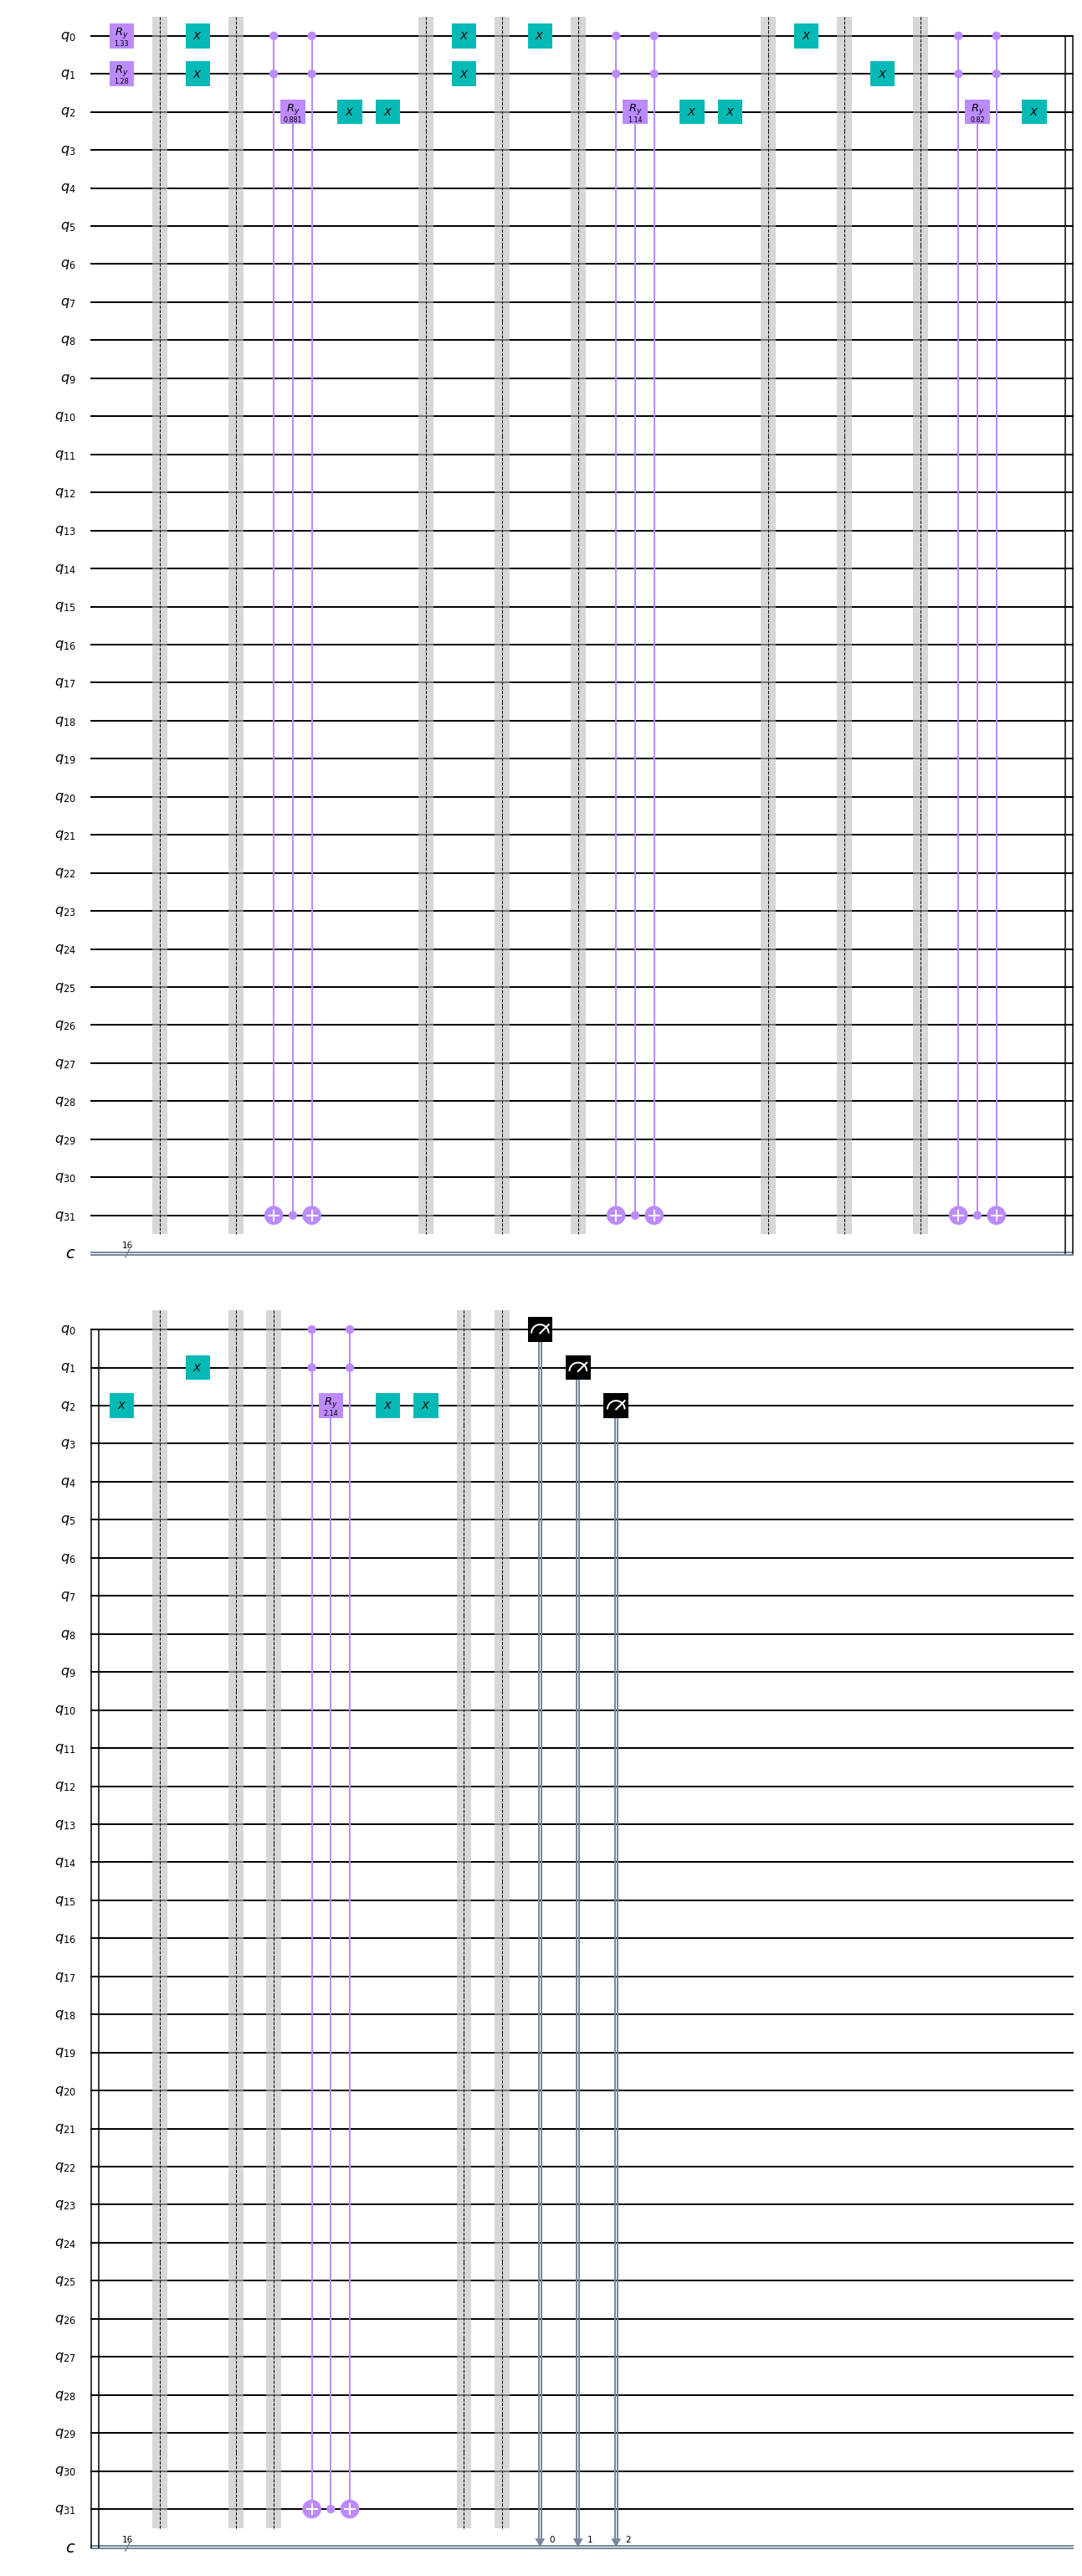

In [15]:
%config InlineBackend.figure_format
qc.draw(output='mpl')
#circuit.draw()

In [ ]:
generate_test_circuit().draw()

In [ ]:
oil_graph = {'IR': ([], [.75, .25]), # From 2004.14803, Fig 10
         'SM': (['IR'], [.3, .7, .8, .2]), #P(0|!A), P(1|!A), P(0|A), P(1|A)
         'OI': ([], [.6, .4]),
         'SP': (['OI', 'SM'], [.9, .1, .5, .5, .4, .6, .2, .8])
        }

liquidity = {'X1': (['X9'], [.488,.552,.067,.933]),
             'X2': (['X4'], [.76,.24,1,0]),
             'X3': (['X5'], [1,0,.949,.051]),
             'X4': (['X9', 'X1'], [.151,.849,.874,.126,1,0,1,0]),
             'X5': (['X8','X4'],[0,1,0,1,.723,.277,.311,.689]),
             'X6': ([], [.98,.02]),
             'X7': (['X6'],[.988,.012,.429,.571]),
             'X8': (['X7'],[.006,.994,.875,.125]),
             'X9': (['X8'],[0,1,.982,.018]),
             'X10': (['X4','X2','X1'],[.684,.316,0,1,0,1,.474,.526,1,0,0,1,.481,.519,1,0])
        
        }


In [ ]:
liq_circuit = create_circuit(liquidity)

In [ ]:
result = run_circuit(liq_circuit, "liquidity", shots=1024*8, draw_circuit=False, use_sim=True, use_qcomp=False, use_noise=False)

In [ ]:
liq_circuit.draw(output='mpl')